# nvImageCodecs with cv-cuda (Linux only)

In [14]:
import os
from matplotlib import pyplot as plt
import torch
import cupy as cp

In [15]:
from torchvision.io.image import read_file, decode_jpeg
os.chdir("/mnt/c/Users/smatysik/projects/nvImageCodecs/build/bin/python")
resources_dir = "../../../resources"
import nvimgcodecs
import nvcv

In [16]:
# "cat_q95_444.jpg"
file_name = "{}/base/tabby_tiger_cat.jpg".format(resources_dir)
inputImage = nvimgcodecs.imread(file_name)
print("size:{}x{}".format(inputImage.width, inputImage.height))

size:720x720


In [ ]:
# I had some problems with nvcv reformat (isnt CHW column-major here? so interleavead) code below so I used cuPy instead
#nvcvInputTensor = nvcv.as_tensor(inputImage, "CHW")
#nvcvInputTensor = nvcvInputTensor.reformat("NHWC")

Convert CHW (Planar) -> NHWC (Interleave)

In [17]:
inputImage = cp.asarray(inputImage)
inputImage = cp.moveaxis(inputImage, (0, 1, 2), (2, 0, 1))
inputImage = cp.asfortranarray(inputImage)
inputImage = cp.ascontiguousarray(inputImage)
inputImage = cp.reshape(
    inputImage, (1, inputImage.shape[0], inputImage.shape[1], inputImage.shape[2]))


Lets pass it to nvcv

In [18]:
nvcvInputTensor = nvcv.as_tensor(inputImage, "NHWC")

Resize with nvcv

In [19]:

nvcvResizeTensor = nvcvInputTensor.resize((1, 320, 320, 3), nvcv.Interp.CUBIC)

For now cv-cuda uses list for strides and shape and cuPy only acceppts tuple as in standard so we woul need to convert it

In [20]:
cuda_array = nvcvResizeTensor.cuda().__cuda_array_interface__
class cuda_array_wrapper:
    __cuda_array_interface__ = {'shape': tuple(cuda_array['shape']), 'strides': tuple(
        cuda_array['strides']), 'typestr': 'B', 'data': cuda_array['data'], 'version': 2}
a = cuda_array_wrapper()

Now it it can be consumed by cuPy

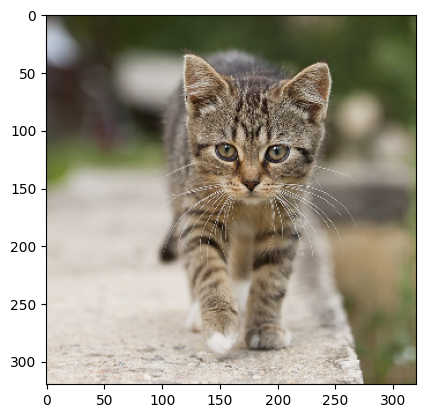

In [21]:
cp_img = cp.asarray(a)
cp_img = cp.reshape(cp_img, (cp_img.shape[1], cp_img.shape[2], cp_img.shape[3]))
image = cp.asnumpy(cp_img)
plt.imshow(image)


## Resnet50 classification example from cv-cuda

In [22]:
from torchvision import models
import numpy as np
file_name = "{}/base/tabby_tiger_cat.jpg".format(resources_dir)
labelsfile = "{}/imagenet-classes.txt".format(resources_dir)

Orignal example code uses torchvision to load image (under the hood it uses nvJpeg)

In [23]:
data = read_file(file_name)
inputImageTmp = decode_jpeg(data, device="cuda")

Now we can change this code to use nvImageCodecs and use all formats available with plugins. Please uncomment lines with other images to test it

In [26]:
#file_name = "{}/base/cat.j2k".format(resources_dir)
file_name = "{}/base/4k_lossless.jp2".format(resources_dir)
inputImage = nvimgcodecs.imread(file_name)

Class :  lakeside, lakeshore  Score :  0.43612173199653625
Class :  promontory, headland, head, foreland  Score :  0.21969959139823914
Class :  cliff, drop, drop-off  Score :  0.12334905564785004
Class :  valley, vale  Score :  0.10275501757860184
Class :  sandbar, sand bar  Score :  0.009075982496142387


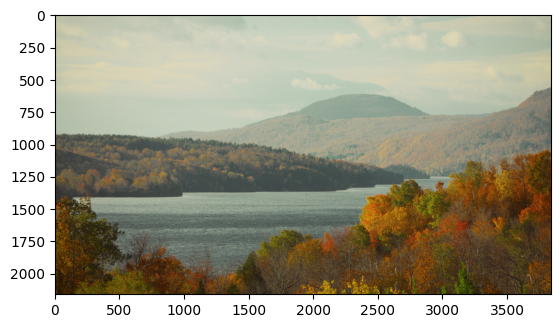

In [27]:
imageWidth = inputImage.width
imageHeight = inputImage.height

#Planar (CHW) -> Interleave (NHWC)
inputImage = cp.asarray(inputImage)
inputImage = cp.moveaxis(inputImage, (0, 1, 2), (2, 0, 1))
inputImage = cp.asfortranarray(inputImage)
inputImage = cp.ascontiguousarray(inputImage)

image = cp.asnumpy(inputImage)
plt.imshow(image)

inputImage = cp.reshape(
    inputImage, (1, inputImage.shape[0], inputImage.shape[1], inputImage.shape[2]))

# A torch tensor/ or nvImageCodecs Image can be wrapped into a CVCUDA Object using the "as_tensor"
# function in the specified layout. The datatype and dimensions are derived
# directly from the torch tensor.
nvcvInputTensor = nvcv.as_tensor(inputImage, "NHWC") 

"""
Preprocessing includes the following sequence of operations.
Resize -> DataType Convert(U8->F32) -> Normalize(Apply mean and std deviation)
-> Interleaved to Planar
"""

# Model settings
layerHeight = 224
layerWidth = 224
batchSize = 1

# Resize
# Resize to the input network dimensions
nvcvResizeTensor = nvcvInputTensor.resize(
    (batchSize, layerHeight, layerWidth, 3), nvcv.Interp.CUBIC)
    
# Convert to the data type and range of values needed by the input layer
# i.e uint8->float. A Scale is applied to normalize the values in the range 0-1
nvcvConvertTensor = nvcvResizeTensor.convertto(np.float32, scale=1 / 255)

"""
The input to the network needs to be normalized based on the mean and
std deviation value to standardize the input data.
"""

# Create a torch tensor to store the mean and standard deviation values for R,G,B
scale = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
scaleTensor = torch.Tensor(scale)
stdTensor = torch.Tensor(std)

# Reshape the the number of channels. The R,G,B values scale and offset will be
# applied to every color plane respectively across the batch
scaleTensor = torch.reshape(scaleTensor, (1, 1, 1, 3)).cuda()
stdTensor = torch.reshape(stdTensor, (1, 1, 1, 3)).cuda()

# Wrap the torch tensor in a CVCUDA Tensor
nvcvScaleTensor = nvcv.as_tensor(scaleTensor, "NHWC")
nvcvBaseTensor = nvcv.as_tensor(stdTensor, "NHWC")

# Apply the normalize operator and indicate the scale values are std deviation
# i.e scale = 1/stddev
nvcvNormTensor = nvcvConvertTensor.normalize(
    nvcvBaseTensor, nvcvScaleTensor, nvcv.NormalizeFlags.SCALE_IS_STDDEV
)
                                                         
# The final stage in the preprocess pipeline includes converting the RGB buffer
# into a planar buffer
nvcvPreprocessedTensor = nvcvNormTensor.reformat("NCHW")   

# Inference uses pytorch to run a resnet50 model on the preprocessed input and outputs
# the classification scores for 1000 classes
# Load Resnet model pretrained on Imagenet
resnet50 = models.resnet50(pretrained=True)
resnet50.to("cuda")
resnet50.eval()

# Run inference on the preprocessed input
torchPreprocessedTensor = torch.as_tensor(nvcvPreprocessedTensor.cuda(), device="cuda")
inferOutput = resnet50(torchPreprocessedTensor)

"""
Postprocessing function normalizes the classification score from the network and sorts
the scores to get the TopN classification scores.
"""
# top results to print out
topN = 5

# Read and parse the classes
with open(labelsfile, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Apply softmax to Normalize scores between 0-1
scores = torch.nn.functional.softmax(inferOutput, dim=1)[0]

# Sort output scores in descending order
_, indices = torch.sort(inferOutput, descending=True)

# Display Top N Results
for idx in indices[0][:topN]:
    print("Class : ", classes[idx], " Score : ", scores[idx].item())


## Original Resnet50 classification with nvcv reformat
This code below does not work as expected - how to make reformat properly?

In [ ]:
#data = read_file("tabby_tiger_cat.jpg")
data = read_file("{}/base/cat_q95_444.jpg".format(resources_dir))
inputImage = decode_jpeg(data, device="cuda")
print("torch: ", inputImage.__cuda_array_interface__)

In [ ]:
nvcvInputTensor = nvcv.as_tensor(inputImage, "CHW")
# this orignal reading format and nvImageCodec as torch can deliver data in this fromat
# However it looks that reformat assumes for CHW column-major so interleave anyway (not planar) and need to be packed pitch for dim2 == 1

In [ ]:
# Convertion  using cuPy from CHW to HWC and delvier to nvcv in this format but something does not work anyway
inputImage = cp.asarray(inputImage)
print("torch->cp: ", inputImage.__cuda_array_interface__)
inputImage = cp.moveaxis(inputImage, (0, 1, 2), (2, 0, 1))
inputImage = cp.asfortranarray(inputImage)
print("cp HWC (column-major): ", inputImage.__cuda_array_interface__)
inputImage = cp.ascontiguousarray(inputImage)
print("cp HWC (row-major): ", inputImage.__cuda_array_interface__)

nvcvInputTensor = nvcv.as_tensor(inputImage, "HWC")
nvcvInputTensor = nvcvInputTensor.reformat("NCHW")
#print("nvcv NCHW: ", nvcvInputTensor.cuda().__cuda_array_interface__)

In [ ]:
nvcvInterleavedTensor =  nvcvInputTensor.reformat("NHWC")
print("nvcv NHWC: ", nvcvInterleavedTensor.cuda().__cuda_array_interface__)

nvcvResizeTensor = nvcvInterleavedTensor.resize((1, 320, 240, 3), nvcv.Interp.CUBIC)

cuda_array = nvcvResizeTensor.cuda().__cuda_array_interface__ 
class cuda_array_wrapper:
    __cuda_array_interface__ = {'shape': tuple(cuda_array['shape']), 'strides': tuple(
        cuda_array['strides']), 'typestr': 'B', 'data': cuda_array['data'], 'version': 2}
a = cuda_array_wrapper()
print("nvcv (tuple) NHWC: ", a.__cuda_array_interface__)

cp_img = cp.asarray(a)
print("cupy NHWC: ", cp_img.__cuda_array_interface__)
cp_img = cp.reshape(
    cp_img, (cp_img.shape[1], cp_img.shape[2], cp_img.shape[3]))
#print("cupy reshaped NHWC: ", cp_img.__cuda_array_interface__)
#cp_img = cp.asfortranarray(cp_img)
#cp_img = cp.ascontiguousarray(cp_img)
image = cp.asnumpy(cp_img)
plt.imshow(image)
